# Modules

In [186]:
%matplotlib inline
import glob, os, sys, timeit
import numpy as np
import re
import sys
import pandas as pd
import random as r
import bisect

%load_ext autoreload
# updates pyqsofit.py
%autoreload 2

sys.path.append('../')
from pyqsofit.PyQSOFit import QSOFit

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import warnings

from pysynphot import observation
from pysynphot import spectrum

warnings.filterwarnings("ignore")

QSOFit.set_mpl_style()

# Show the versions so we know what works
import astropy
import lmfit
import pyqsofit

print(astropy.__version__)
print(lmfit.__version__)
print(pyqsofit.__version__)

import emcee  # optional, for MCMC

print(emcee.__version__)

print(pyqsofit.__path__) # Check path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
5.3.4
1.2.2
2.1.6
3.1.4
['/Users/joel/anaconda3/lib/python3.11/site-packages/pyqsofit']


# Read Spectrum

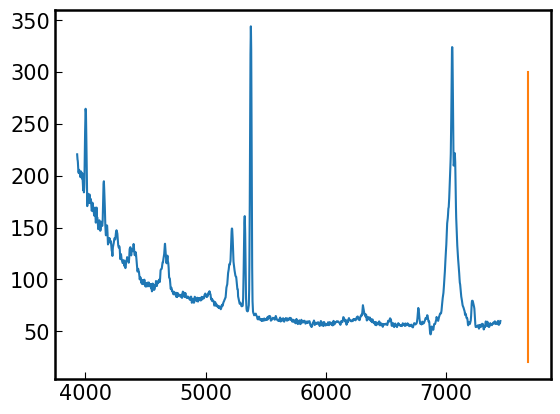

In [187]:
# Prepare data for SDSS
# Rebin_spec
def rebin_spec(wave, specin, wavnew):
    spec = spectrum.ArraySourceSpectrum(wave=wave, flux=specin)
    f = np.ones(len(wave))
    filt = spectrum.ArraySpectralElement(wave, f, waveunits='angstrom')
    obs = observation.Observation(spec, filt, binset=wavnew, force='taper')
    return obs.binflux

# Function that reads in the data from txt. files
def readTxt(file_path):
    # Initialize empty lists to be returned
    wavelength_list = []
    flux_list = []
    flux_err_list = []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Check the row begins with a number - not holding a column title
            if line[0].isnumeric():
                # Split each line into separate values separated by one or more space or commas
                values = re.split(r'[\s,]+', line.strip())
                # Convert the values to floats and append them to the respective lists
                if len(values) > 1:
                    wavelength_list.append(float(values[0]))
                    flux_list.append(float(values[1]))
                    flux_err_list.append(float(values[2]))
        # Convert to numpy array for easier manipulation
        wavelength_arr = np.array(wavelength_list)
        flux_arr = np.array(flux_list)
        flux_err_arr = np.array(flux_err_list)
    return(wavelength_arr, flux_arr, flux_err_arr)


path_out = os.path.join(pyqsofit.__path__[0], '../', '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/ZTF18abuamgo_Analysis')

'''
# 2004
# Required
file_path_2009 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/6df_spectra/6dFJ0245455-030450-S-VR-j2009.txt'
wave, flux, err = readTxt(file_path_2009)
z = 0.074550  # Redshift

# These steps here is how you turn any spectrum into a sdss spectrum - rebin_spec is a very handy function
wavenew = np.arange(wave[0], wave[-1], 10 ** 1e-4)
flux = rebin_spec(wave, flux, wavenew) * 0.024643971103449368*3.145 # Rescaled to 2022 then the 3 from 2022 to 2024
err = rebin_spec(wave, err, wavenew) * 0.024643971103449368*3.145
lam = wavenew
'''
# 2022
file_path_2022 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/10JYSElqi_gr4_2022-09-09T05h46h03s_final_red.txt'
wave, flux, err = readTxt(file_path_2022)
z = 0.074550  # Redshift

# These steps here is how you turn any spectrum into a sdss spectrum - rebin_spec is a very handy function
wavenew = np.arange(wave[0], wave[-1], 10 ** 1e-4)
flux = rebin_spec(wave, flux, wavenew) * 3.145 * 1e17 # scale 2022 to 2024 and SDSS units of flux in terms of 1e-17
err = rebin_spec(wave, err, wavenew) * 3.145 * 1e17
lam = wavenew
'''
# 2024
file_path_2024 = '/Users/joel/Library/CloudStorage/OneDrive-UniversityofSouthampton/Post Grad/ZTF18abuamgo_CLAGN_Project/Data/10JYSElqi_spectra/28_August_2024_spec/10JYSElqi_WiFeS_20240828.csv'
wave, flux = readTxt(file_path_2024)
err = flux*0.1
z = 0.074550  # Redshift

# These steps here is how you turn any spectrum into a sdss spectrum - rebin_spec is a very handy function
wavenew = np.arange(wave[0], wave[-1], 10 ** 1e-4)
flux = rebin_spec(wave, flux, wavenew) * 1e17 # SDSS units of flux in terms of 1e-17
err = flux*0.1
lam = wavenew
'''


# Apply wave_mask here since PyQSOFit doesn't work with wave_mask at the moment.
indices_to_remove = np.where((lam < 3933) | ((lam > 5271) & (lam < 5283)) | (lam > 7450))[0] # once corrected for redshift: 3660 (red end), ~4905-4915, 6930 (blue end)

flux = np.delete(flux, indices_to_remove)
err = np.delete(err, indices_to_remove)
lam = np.delete(lam, indices_to_remove)

# Optional
ra = 41.43958  # RA
dec = -3.08047  # DEC

plt.plot(lam, flux)
mark = 7680
plt.plot([mark, mark], [20, 300])
plt.show()

# Model Parameters

In [188]:
path_ex = '.' #os.path.join(pyqsofit.__path__[0], '..', 'example')

# create a header
hdr0 = fits.Header()
hdr0['Author'] = 'Joel Carpenter'
primary_hdu = fits.PrimaryHDU(header=hdr0)

In [189]:
"""
In this table, we specify the priors / initial conditions and boundaries for the line fitting parameters.
"""
'''
INITIAL SEPARATE LINE COMPLEXES
line_priors = np.rec.array([
    #lambda, compname,   minwav,  maxwav, linename, ngauss, inisca, minsca, maxsca,     inisig, minsig, maxsig,     voff, vindex, windex, findex, fvalue, vary
    (6564.61, 'Ha',         6400, 6760,     'Ha_br', 2,         0.0, 0.0, 1e10,         5e-3, 0.004, 0.05,          0.015, 0,   0,   0, 0.05, 1),
    (6564.61, 'Ha',         6400, 6760,     'Ha_na', 1,         0.0, 0.0, 1e10,         1e-3, 5e-4, 0.00169,        0.01, 1,    1,   0, 0.002, 1),
    (6549.85, 'Ha',         6400, 6760,     'NII6549', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.001, 1),
    (6585.28, 'Ha',         6400, 6760,     'NII6585', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.003, 1),
    (6718.29, 'Ha',         6400, 6760,     'SII6718', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    (6732.67, 'Ha',         6400, 6760,     'SII6732', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    
    (6300.30, 'OI',         6270, 6330,     'OI6300', 1,        0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   0, 0.001, 1),
    
    (5875.62, 'HeI',        5500, 6200,     'HeI5875_br', 1,    0.0, 0.0, 1e10,         1e-3, 5e-4, 2e-2,           5e-3, 1,    0,   0, 0.001, 1),
    (5875.62, 'HeI',        5500, 6200,     'HeI5875_na', 1,    0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   0, 0.001, 1),

    (4862.68, 'Hb',         4570, 5100,     'Hb_br', 2,         0.0, 0.0, 1e10,         5e-3, 0.004, 0.05,          0.01, 0,    0,   0, 0.01, 1),
    (4862.68, 'Hb',         4570, 5100,     'Hb_na', 1,         0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.01, 1,    1,   0, 0.002, 1),
    (4960.30, 'Hb',         4570, 5100,     'OIII4959c', 1,     0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.01, 1,    1,   0, 0.002, 1),
    (5008.24, 'Hb',         4570, 5100,     'OIII5007c', 1,     0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.01, 1,    1,   0, 0.004, 1),
    (4960.30, 'Hb',         4570, 5100,     'OIII4959w', 1,     0.0, 0.0, 1e10,         3e-3, 2.3e-4, 0.004,        0.01, 2,    2,   0, 0.001, 1),
    (5008.24, 'Hb',         4570, 5100,     'OIII5007w', 1,     0.0, 0.0, 1e10,         3e-3, 2.3e-4, 0.004,        0.01, 2,    2,   0, 0.002, 1),
    (4687.02, 'Hb',         4570, 5100,     'HeII4687_br', 1,   0.0, 0.0, 1e10,         5e-3, 0.004,  0.05,         0.005, 0,   0,   0, 0.001, 1),
    (4687.02, 'Hb',         4570, 5100,     'HeII4687_na', 1,   0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.005, 1,   1,   0, 0.001, 1),
    
    (4341.68, 'Hg',         4260, 4410,     'Hg_br', 1,         0.0, 0, 40,             5e-3, 0.002, 0.05,          0.01, 1,    0,   0, 0.001, 1),
    (4341.68, 'Hg',         4260, 4410,     'Hg_na', 1,         0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   0, 0.001, 1),
    
    (4101.74, 'Hd',         4000, 4200,     'Hd_br', 1,         0.0, 0, 30,             5e-3, 0.004, 0.05,          0.01, 1,    0,   0, 0.001, 1),
    (4101.74, 'Hd',         4000, 4200,     'Hd_na', 1,         0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   0, 0.001, 1),

    (3970.08, 'Hep',        3880, 4040,     'Hep_br', 1,        0.0, 0, 30,             5e-3, 0.004, 0.05,          0.01, 1,    0,   0, 0.001, 1),
    (3970.08, 'Hep',        3880, 4040,     'Hep_na', 1,        0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   0, 0.001, 1),
    
    (3868.76, 'NeIII',      3820, 3920,     'NeIII3868', 1,     0.0, 0, 150,            1e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   0, 0.001, 1),
    
    (3728.48, 'OII',        3700, 3750,     'OII3728', 1,       0.0, -10, 150,          1e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   0, 0.001, 1),
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')
'''
'''
line_priors = np.rec.array([
    #lambda, compname,   minwav,  maxwav, linename, ngauss, inisca, minsca, maxsca,     inisig, minsig, maxsig,     voff, vindex, windex, findex, fvalue, vary
    (6564.61, 'All',        3660, 6760,     'Ha_br', 2,         0.0, 0.0, 1e10,         5e-3, 0.004, 0.05,          0.015, 0,   0,   0, 0.05, 1), # Ha
    (6564.61, 'All',        3660, 6760,     'Ha_na', 1,         0.0, 0.0, 1e10,         1e-3, 5e-4, 0.00169,        0.01, 1,    5,   16, 0.002, 1),
    (6549.85, 'All',        3660, 6760,     'NII6549', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.001, 1),
    (6585.28, 'All',        3660, 6760,     'NII6585', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.003, 1), # 1-3 flux ratio between NII lines
    (6718.29, 'All',        3660, 6760,     'SII6718', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    (6732.67, 'All',        3660, 6760,     'SII6732', 1,       0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    
    (6300.30, 'All',        3660, 6760,     'OI6300', 1,        0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      5e-3, 2,    1,   3, 0.001, 1), # OI
    
    (5875.62, 'All',        3660, 6760,     'HeI5875_br', 1,    0.0, 0.0, 1e10,         1e-3, 5e-4, 2e-2,           5e-3, 1,    3,   4, 0.001, 1), # HeI
    (5875.62, 'All',        3660, 6760,     'HeI5875_na', 1,    0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   4, 0.001, 1),

    (4862.68, 'All',        3660, 6760,     'Hb_br', 2,         0.0, 0.0, 1e10,         5e-3, 0.004, 0.05,          0.01, 0,    0,   5, 0.01, 1), # Hb
    (4862.68, 'All',        3660, 6760,     'Hb_na', 1,         0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.01, 1,    6,   17, 0.002, 1),
    (4960.30, 'All',        3660, 6760,     'OIII4959c', 1,     0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.01, 1,    4,   6, 0.002, 1),
    (5008.24, 'All',        3660, 6760,     'OIII5007c', 1,     0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.01, 1,    4,   6, 0.006, 1), # 1-3 flux ratio between OIII lines
    #(4960.30, 'All',        3660, 6760,     'OIII4959w', 1,     0.0, 0.0, 1e10,         3e-3, 2.3e-4, 0.004,        0.01, 2,    2,   7, 0.001, 1),
    #(5008.24, 'All',        3660, 6760,     'OIII5007w', 1,     0.0, 0.0, 1e10,         3e-3, 2.3e-4, 0.004,        0.01, 2,    2,   7, 0.002, 1),
    (4687.02, 'All',        3660, 6760,     'HeII4687_br', 1,   0.0, 0.0, 1e10,         5e-3, 0.004,  0.05,         0.005, 0,   2,   8, 0.001, 1),
    (4687.02, 'All',        3660, 6760,     'HeII4687_na', 1,   0.0, 0.0, 1e10,         1e-3, 2.3e-4, 0.00169,      0.005, 1,   1,   9, 0.001, 1),
    
    (4341.68, 'All',        3660, 6760,     'Hg_br', 1,         0.0, 0, 40,             5e-3, 0.002, 0.05,          0.01, 0,    0,   10, 0.001, 1), # Hg
    (4341.68, 'All',        3660, 6760,     'Hg_na', 1,         0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   10, 0.001, 1),
    
    (4101.74, 'All',        3660, 6760,     'Hd_br', 1,         0.0, 0, 30,             5e-3, 0.004, 0.05,          0.01, 0,    0,   11, 0.001, 1), # Hd
    (4101.74, 'All',        3660, 6760,     'Hd_na', 1,         0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   11, 0.001, 1),

    (3970.08, 'All',        3660, 6760,     'Hep_br', 1,        0.0, 0, 30,             5e-3, 0.004, 0.05,          0.01, 0,    0,   12, 0.001, 1), # Hep
    (3970.08, 'All',        3660, 6760,     'Hep_na', 1,        0.0, 0, 30,             1e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   13, 0.001, 1),
    
    (3868.76, 'All',        3660, 6760,     'NeIII3868', 1,     0.0, 0, 150,            1e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   14, 0.001, 1), # NeIII
    
    (3728.48, 'All',        3660, 6760,     'OII3728', 1,       0.0, -10, 150,          1e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   15, 0.001, 1), # OII
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')
'''
line_priors = np.rec.array([
    #lambda, compname,   minwav,  maxwav, linename, ngauss, inisca, minsca, maxsca,     inisig, minsig, maxsig,     voff, vindex, windex, findex, fvalue, vary
    (6564.61, 'All',        3660, 6760,     'Ha_br', 1,         137.1, 0.0, 1e10,       6.4e-3, 0.004, 0.05,          0.015, 0,   0,   0, 0.05, 1), # Ha
    (6564.61, 'All',        3660, 6760,     'Ha_na', 1,         138.3, 0.0, 1e10,       8.9e-4, 5e-4, 0.00169,        0.01, 1,    5,   16, 0.002, 1),
    (6549.85, 'All',        3660, 6760,     'NII6549', 1,       18.50, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.001, 1),
    (6585.28, 'All',        3660, 6760,     'NII6585', 1,       55.49, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   1, 0.003, 1), # 1-3 flux ratio between NII lines
    (6718.29, 'All',        3660, 6760,     'SII6718', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    (6732.67, 'All',        3660, 6760,     'SII6732', 1,       16.71, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 1,    1,   2, 0.001, 1),
    
    (6300.30, 'All',        3660, 6760,     'OI6300', 1,        14.73, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      5e-3, 2,    1,   3, 0.001, 1), # OI
    
    (5875.62, 'All',        3660, 6760,     'HeI5875_br', 1,    8.881, 0.0, 1e10,       2.0e-2, 5e-4, 2e-2,           5e-3, 1,    3,   4, 0.001, 1), # HeI
    (5875.62, 'All',        3660, 6760,     'HeI5875_na', 1,    8.881, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   4, 0.001, 1),

    (4862.68, 'All',        3660, 6760,     'Hb_br', 1,         55.17, 0.0, 1e10,       7.6e-3, 0.004, 0.05,          0.01, 0,    0,   5, 0.01, 1), # Hb
    (4862.68, 'All',        3660, 6760,     'Hb_na', 1,         36.03, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    6,   17, 0.002, 1),
    (4960.30, 'All',        3660, 6760,     'OIII4959c', 1,     102.4, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    4,   6, 0.002, 1),
    (5008.24, 'All',        3660, 6760,     'OIII5007c', 1,     307.1, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.01, 1,    4,   6, 0.006, 1), # 1-3 flux ratio between OIII lines
    (4687.02, 'All',        3660, 6760,     'HeII4687_br', 1,   14.35, 0.0, 1e10,       1.1e-2, 0.004,  0.05,         0.005, 0,   2,   8, 0.001, 1),
    (4687.02, 'All',        3660, 6760,     'HeII4687_na', 1,   5.956, 0.0, 1e10,       1.2e-3, 2.3e-4, 0.00169,      0.005, 1,   1,   9, 0.001, 1),
    
    (4341.68, 'All',        3660, 6760,     'Hg_br', 1,         29.56, 0, 40,           6.8e-3, 0.002, 0.05,          0.01, 0,    0,   10, 0.001, 1), # Hg
    (4341.68, 'All',        3660, 6760,     'Hg_na', 1,         29.56, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   10, 0.001, 1),
    
    (4101.74, 'All',        3660, 6760,     'Hd_br', 1,         15.27, 0, 30,           6.0e-3, 0.004, 0.05,          0.01, 0,    0,   11, 0.001, 1), # Hd
    (4101.74, 'All',        3660, 6760,     'Hd_na', 1,         15.27, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   11, 0.001, 1),

    (3970.08, 'All',        3660, 6760,     'Hep_br', 1,        12.31, 0, 30,           4.0e-3, 0.004, 0.05,          0.01, 0,    0,   12, 0.001, 1), # Hep
    (3970.08, 'All',        3660, 6760,     'Hep_na', 1,        10.57, 0, 30,           1.2e-3, 3.333e-4, 0.00169,    0.01, 1,    1,   13, 0.001, 1),
    
    (3868.76, 'All',        3660, 6760,     'NeIII3868', 1,     51.49, 0, 150,          1.2e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   14, 0.001, 1), # NeIII
    
    (3728.48, 'All',        3660, 6760,     'OII3728', 1,       91.21, -10, 150,        1.2e-3, 3.333e-4, 0.0025,     0.01, 1,    1,   15, 0.001, 1), # OII
    ],

    formats='float32,    a20,  float32, float32,      a20,  int32, float32, float32, float32, float32, float32, float32, float32,   int32,  int32,  int32, float32, int32',
    names=' lambda, compname,   minwav,  maxwav, linename, ngauss,  inisca,  minsca,  maxsca,  inisig,  minsig,  maxsig,    voff,  vindex, windex, findex,  fvalue,  vary')

'''
In this table we include one large line complex to tie line properties between Balmer emission lines
'''
#'''
# Header
hdr1 = fits.Header()
hdr1['lambda'] = 'Vacuum Wavelength in Ang'
hdr1['minwav'] = 'Lower complex fitting wavelength range'
hdr1['maxwav'] = 'Upper complex fitting wavelength range'
hdr1['ngauss'] = 'Number of Gaussians for the line'

# Can be set to negative for absorption lines if you want
hdr1['inisca'] = 'Initial guess of line scale [flux]'
hdr1['minsca'] = 'Lower range of line scale [flux]'
hdr1['maxsca'] = 'Upper range of line scale [flux]'

hdr1['inisig'] = 'Initial guess of linesigma [lnlambda]'
hdr1['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr1['maxsig'] = 'Upper range of line sigma [lnlambda]'

hdr1['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr1['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr1['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr1['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr1['fvalue'] = 'Relative scale factor for entries w/ same findex'

hdr1['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the line parameter to initial values)'

# Save line info
hdu1 = fits.BinTableHDU(data=line_priors, header=hdr1, name='line_priors')

In [190]:
"""
In this table, we specify the windows and priors / initial conditions and boundaries for the continuum fitting parameters.
"""

conti_windows = np.rec.array([
    #(3570., 3660.), # I added this low end cont
    (3670., 3700.), #3600 Lower limit looks better for edge of spectrum but reduces chi2 fit of OII line
    (3775., 3832.), # Previous lowest wav cont window included in the example in my range for 2022 spectrum
    (4000., 4035.),
    (4170., 4230.),
    (4435., 4620.),
    (5100., 5535.),
    (6005., 6035.),
    (6110., 6250.),
    #(6800., 6850)
    (6800., 7000.),
    #(7160., 7180.),
    #(7500., 7800.),
    #(8050., 8150.), # Continuum fitting windows (to avoid emission line, etc.)  [AA]
    ], 
    formats = 'float32,  float32',
    names =    'min,     max')

hdu2 = fits.BinTableHDU(data=conti_windows, name='conti_windows')

conti_priors = np.rec.array([
    # parname, initial, min, max, vary
    ('Fe_uv_norm',  0.0,   0.0,   1e10,  1), # Normalization of the MgII Fe template [flux]
    ('Fe_uv_FWHM',  3000,  1200,  18000, 1), # FWHM of the MgII Fe template [AA]
    ('Fe_uv_shift', 0.0,   -0.01, 0.01,  1), # Wavelength shift of the MgII Fe template [lnlambda]
    ('Fe_op_norm',  0.0,   0.0,   1e10,  1), # Normalization of the Hbeta/Halpha Fe template [flux]
    ('Fe_op_FWHM',  3000,  1200,  18000, 1), # FWHM of the Hbeta/Halpha Fe template [AA]
    ('Fe_op_shift', 0.0,   -0.01, 0.015,  1), # Wavelength shift of the Hbeta/Halpha Fe template [lnlambda] was 0.01 upper lim
    ('PL_norm',     1.0,   0.0,   1e10,  1), # Normalization of the power-law (PL) continuum f_lambda = (lambda/3000)^-alpha
    ('PL_slope',    -1.5,  -15.0,  0.0,   1), # Slope of the power-law (PL) continuum
    ('Blamer_norm', 0.0,   0.0,   1e10,  1), # Normalization of the Balmer continuum at < 3646 AA [flux] (Dietrich et al. 2002)
    ('Balmer_Te',   15000, 10000, 50000, 1), # Te of the Balmer continuum at < 3646 AA [K?]
    ('Balmer_Tau',  0.5,   0.1,   2.0,   1), # Tau of the Balmer continuum at < 3646 AA
    ('conti_a_0',   0.0,   None,  None,  1), # 1st coefficient of the polynomial continuum
    ('conti_a_1',   0.0,   None,  None,  1), # 2nd coefficient of the polynomial continuum
    ('conti_a_2',   0.0,   None,  None,  1), # 3rd coefficient of the polynomial continuum
    # Note: The min/max bounds on the conti_a_0 coefficients are ignored by the code,
    # so they can be determined automatically for numerical stability.
    ],

    formats = 'a20,  float32, float32, float32, int32',
    names = 'parname, initial,   min,     max,     vary')

hdr3 = fits.Header()
hdr3['ini'] = 'Initial guess of line scale [flux]'
hdr3['min'] = 'FWHM of the MgII Fe template'
hdr3['max'] = 'Wavelength shift of the MgII Fe template'

hdr3['vary'] = 'Whether or not to vary the parameter (set to 0 to fix the continuum parameter to initial values)'


hdu3 = fits.BinTableHDU(data=conti_priors, header=hdr3, name='conti_priors')

In [191]:
"""
In this table, we allow user to customized some key parameters in our result measurements.
"""

measure_info = Table(
    [
        [[1350, 1450, 3000, 4200, 5100]],
        [[
            # [2240, 2650], 
            [4435, 4685],
        ]]
    ],
    names=([
        'cont_loc',
        'Fe_flux_range'
    ]),
    dtype=([
        'float32',
        'float32'
    ])
)
hdr4 = fits.Header()
hdr4['cont_loc'] = 'The wavelength of continuum luminosity in results'
hdr4['Fe_flux_range'] = 'Fe emission wavelength range calculated in results'

hdu4 = fits.BinTableHDU(data=measure_info, header=hdr4, name='measure_info')

hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)

# Fit Model

Fitting finished in 1.0s


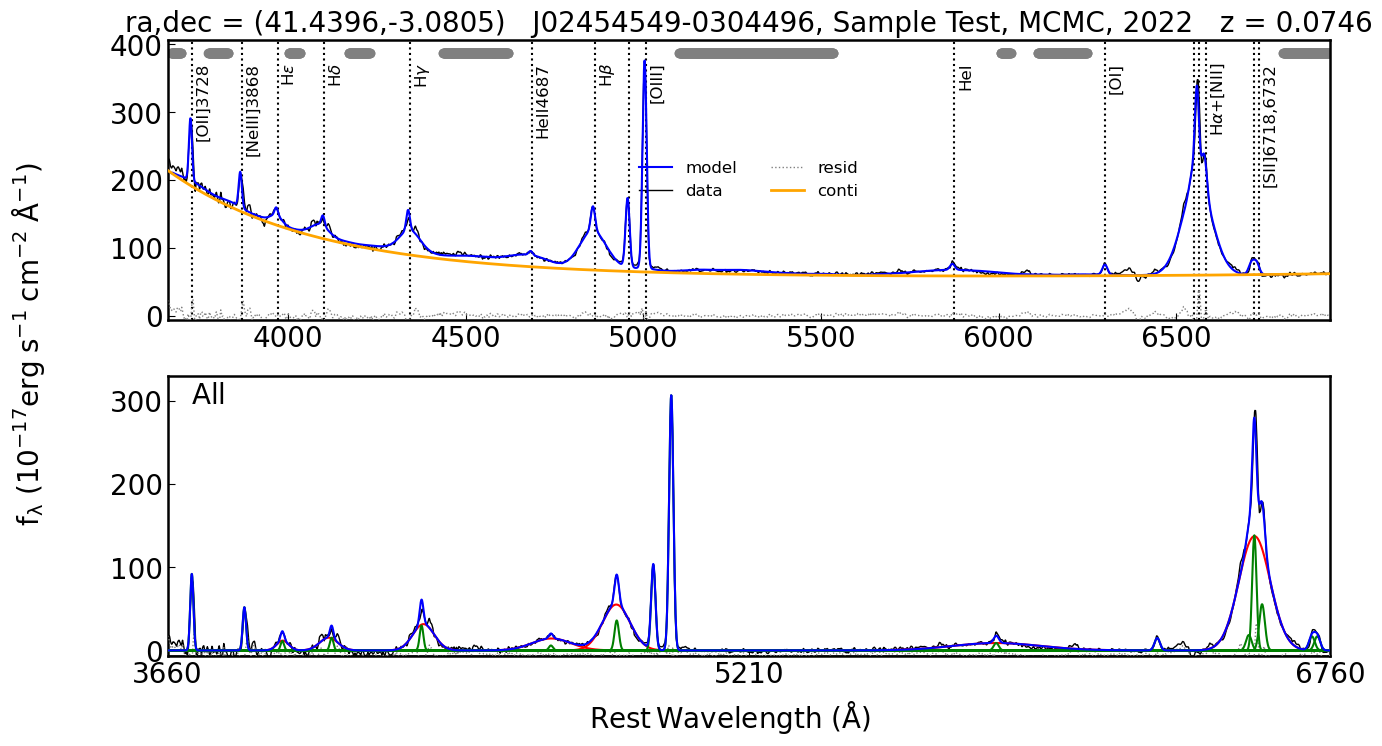

In [192]:
q_mcmc = QSOFit(lam, flux, err, z, ra=ra, dec=dec, path=path_ex)

start = timeit.default_timer()
# Do the fitting
q_mcmc.Fit(name='J02454549-0304496, Sample Test, MCMC, 2022', nsmooth=1, deredden=False, reject_badpix=False, wave_range=None, \
           wave_mask=None, decompose_host=False, host_prior=False, host_prior_scale=0.1, decomp_na_mask=True, npca_gal=5, host_type='PCA', npca_qso=10, \
           qso_type='DZBIN1', Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MCMC=False, nsamp=800, linefit=True, \
           plot_fig=True, save_fig=False, save_result=False, plot_corner=False, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None, verbose=False)

end = timeit.default_timer()
                
print(f'Fitting finished in {np.round(end - start, 1)}s')

# Save Results

In [171]:
# Tabulate Line Parameters
line_name = ['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII5007c', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hd_br', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728']
line_type = ['broad', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'narrow', 'narrow', 'narrow', 'broad', 'narrow', 'broad', 'broad', 'broad', 'narrow', 'narrow', 'narrow']
fwhm_list = []
sigma_list = []
ew_list = []
peak_list = []
area_list = []
snr_list = []

for i in range(len(line_name)):
    fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name(line_name[i], line_type[i])
    fwhm_list.append(fwhm)
    sigma_list.append(sigma)
    ew_list.append(ew)
    peak_list.append(peak)
    area_list.append(area)
    snr_list.append(snr)


# Use pandas dataframe to display the parameters
my_dict = {'Line': line_name, 'Type': line_type, 'FWHM': fwhm_list, 'Sigma': sigma_list, 'EW': ew_list, 'Peak': peak_list, 'Area': area_list, 'SNR': snr_list}

# specifying the columns makes sure they are in the desired order
df = pd.DataFrame(my_dict, columns=['Line', 'Type', 'FWHM', 'Sigma', 'EW', 'Peak', 'Area', 'SNR'])

print('MY LINE PARAMETER DATAFRAME')
df

MY LINE PARAMETER DATAFRAME


,Line,Type,FWHM,Sigma,EW,Peak,Area,SNR
0,Ha_br,broad,4490.336176,1881.358634,240.755022,6558.651925,14341.394406,36.850565
1,Ha_na,narrow,627.804773,262.883181,33.937581,6558.199109,2021.281639,22.374309
2,NII6549,narrow,811.366013,339.819286,5.855416,6543.449116,348.381872,3.105575
3,NII6585,narrow,811.366237,339.819380,17.616695,6578.845998,1050.799347,8.327242
4,SII6718,narrow,811.366077,339.819312,5.437234,6711.724972,327.886212,1.820889
5,SII6732,narrow,811.366091,339.819318,5.441674,6726.090918,328.588028,1.856261
6,OI6300,narrow,812.035454,340.099663,4.600831,6299.335863,270.161547,2.804552
7,HeI5875_br,broad,14106.656197,5913.208093,44.637483,5869.880253,2610.219933,4.880604
8,HeI5875_na,narrow,811.366319,339.819414,2.569177,5869.880253,150.098196,2.651916
9,Hb_br,broad,5338.267648,2236.679446,75.498843,4856.725077,5070.581701,11.953306


In [172]:
line_parameters = np.column_stack((q_mcmc.line_result_name, q_mcmc.line_result))
print(line_parameters)

[['1_complex_name' 'All']
 ['1_line_status' '1']
 ['1_line_min_chi2' '400.5033165590683']
 ['1_line_bic' '-6726.811483156174']
 ['1_line_red_chi2' '0.12199309063632906']
 ['1_niter' '603']
 ['1_ndof' '3283']
 ['Ha_br_1_scale' '137.39248461153153']
 ['Ha_br_1_centerwave' '8.788540361535363']
 ['Ha_br_1_sigma' '0.006366352750486177']
 ['Ha_na_1_scale' '138.52912983391974']
 ['Ha_na_1_centerwave' '8.788471318196814']
 ['Ha_na_1_sigma' '0.000890135990212835']
 ['NII6549_1_scale' '18.514850208539713']
 ['NII6549_1_centerwave' '8.786219693135779']
 ['NII6549_1_sigma' '0.0011504204665282642']
 ['NII6585_1_scale' '55.54455062561914']
 ['NII6585_1_centerwave' '8.79161462874369']
 ['NII6585_1_sigma' '0.0011504204665282642']
 ['SII6718_1_scale' '16.988709328202845']
 ['SII6718_1_centerwave' '8.811611271810095']
 ['SII6718_1_sigma' '0.0011504204665282642']
 ['SII6732_1_scale' '16.988709328202845']
 ['SII6732_1_centerwave' '8.813749409627478']
 ['SII6732_1_sigma' '0.0011504204665282642']
 ['OI6300_

Find Averages

In [232]:
# Import residuals and obtain residual std dev across spectrum in 100A bins
residuals_2022 = np.load("residuals_2022.npy")
bounds = np.arange(int(min(lam)/100)*100 + 100, int(max(lam)/100)*100 + 200, 100) # create 100 Angstrom bins covering the range of lam upper lims (4000-7500)
residual_means = []
residual_std = []
lower_bound_index = 0
bounds_index = []
for b in range(len(bounds)): # loop through boundaries
    upper_bound_index = bisect.bisect_right(lam, bounds[b]) # finds index of each boundary (pointing right)
    bounds_index.append(upper_bound_index) # stores list of all boundary indexes
    
    residual_means.append(np.mean(residuals_2022[lower_bound_index:upper_bound_index])) # append residual mean from current 100A region
    residual_std.append(np.std(residuals_2022[lower_bound_index:upper_bound_index])) # append std dev of residuals from current 100A region
    
    lower_bound_index = upper_bound_index # adjust new lower bound up

print(residual_means)
print(residual_std)
print(bounds_index)

[6.494860118946049, 0.4589175435629899, -0.10550078106747343, -0.9454678833586426, -0.6149804072174669, -1.2969234084471553, -2.7396593043229696, 0.50632415579882, 0.6436581907465632, 1.2566545345198965, 0.0391278275751427, -0.049937146441985346, 0.3148344313225304, -0.24950406435955433, 1.410451682113246, 0.9308877005429482, -0.4697678256778787, -1.5219839870439886, -0.42706833943716227, 0.4843865735705918, 0.8894341369396787, 1.6666192940652926, 1.2285369075728285, -0.05083927309795568, 0.42632502840803027, -2.177694232727509, 0.9019828504344852, 0.03679980137381508, -0.1571626539816477, 1.6471614470489786, 0.1703262727500197, 2.06449638014569, 0.7561754981987237, -1.075354359186561, -0.608063003464702, 0.9155500001913743]
[7.359827686047833, 6.923153407737016, 7.310594129872502, 3.664039604701477, 3.8387922417147813, 4.233230294220151, 2.2071519488913367, 5.590629847848003, 2.2818000572192942, 2.192637166722016, 1.4744411133770383, 1.1331862730093532, 2.1370118685312978, 1.741577939

Fit_0 finished in 1.2s
Fit_1 finished in 1.0s
Fit_2 finished in 1.5s
Fit_3 finished in 1.0s
Fit_4 finished in 1.3s


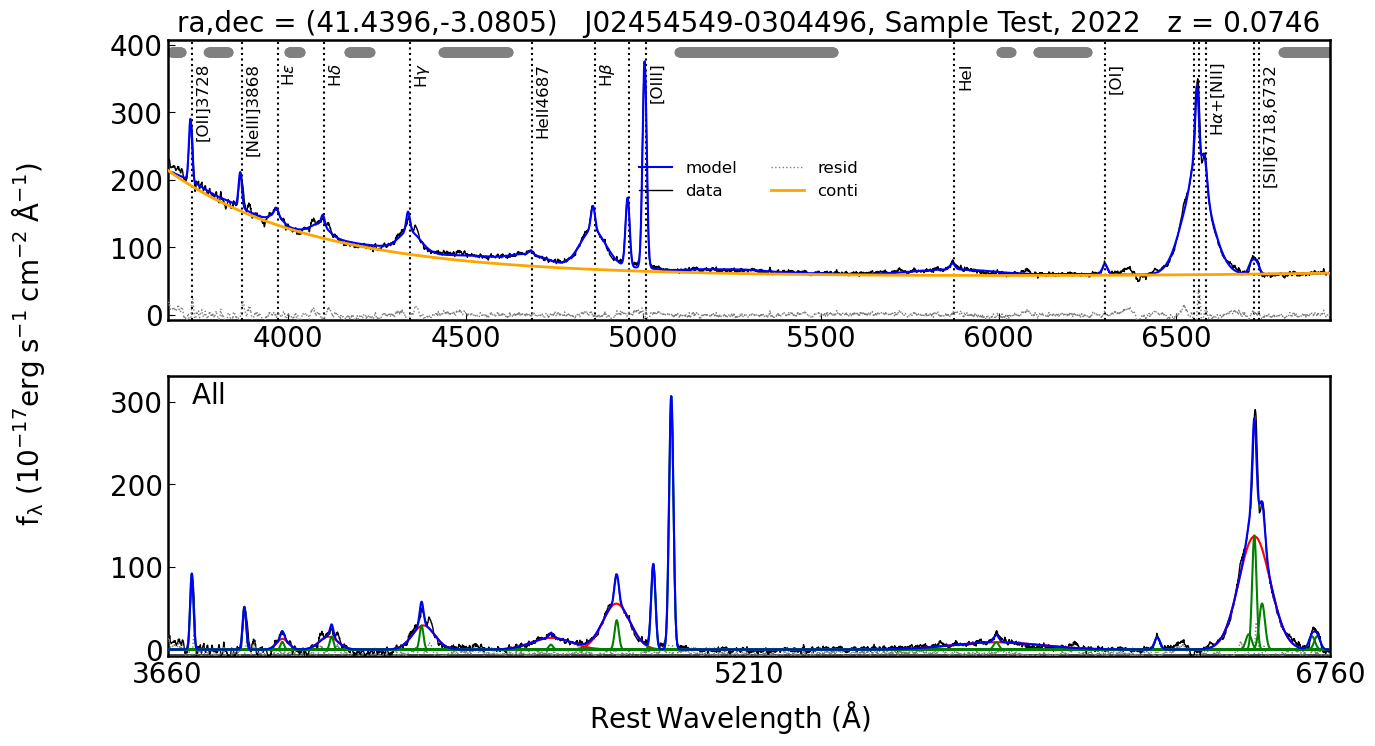

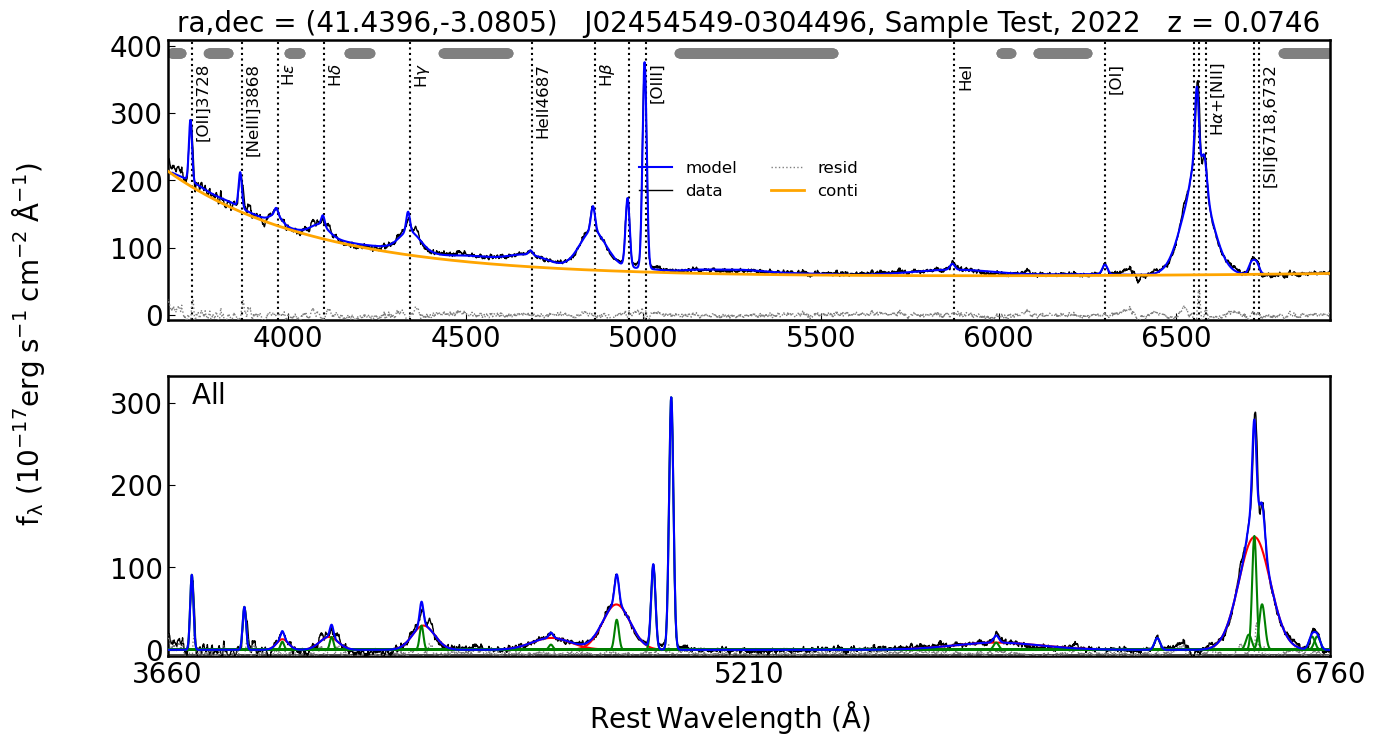

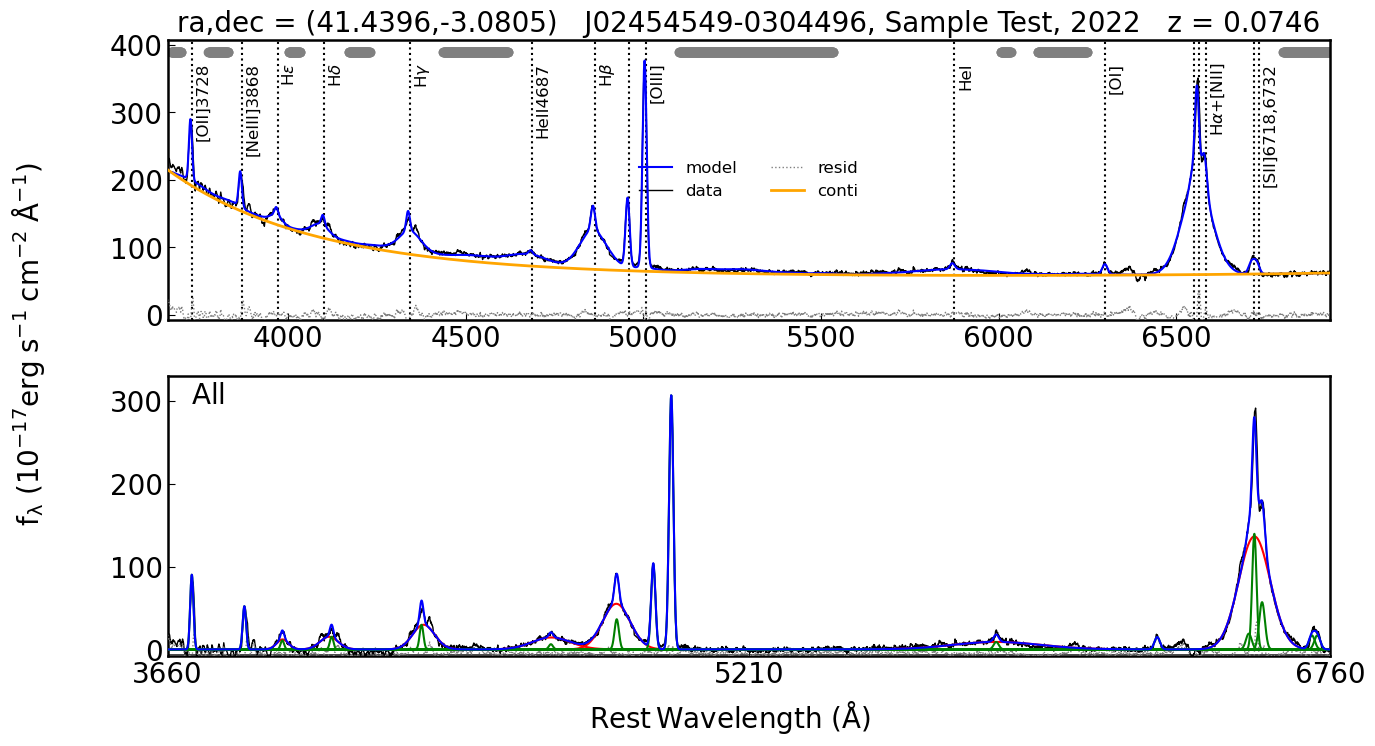

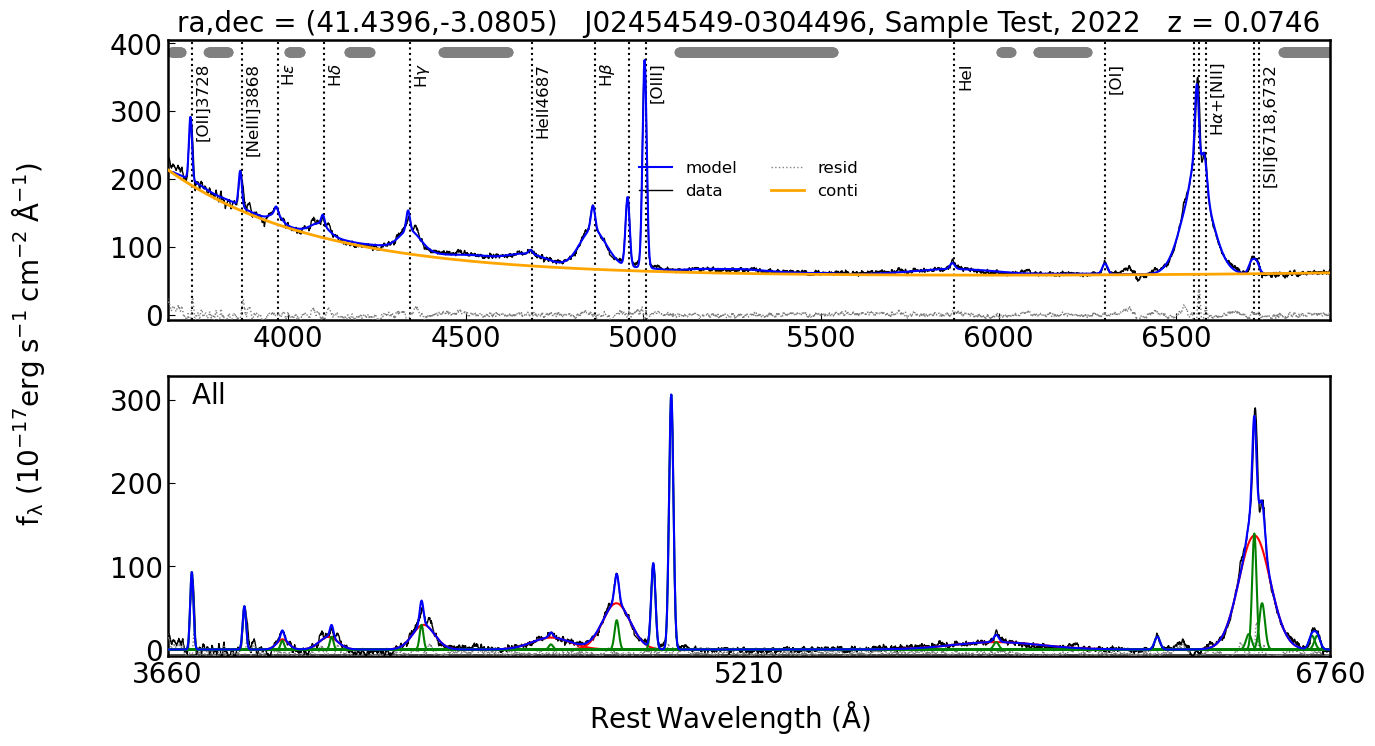

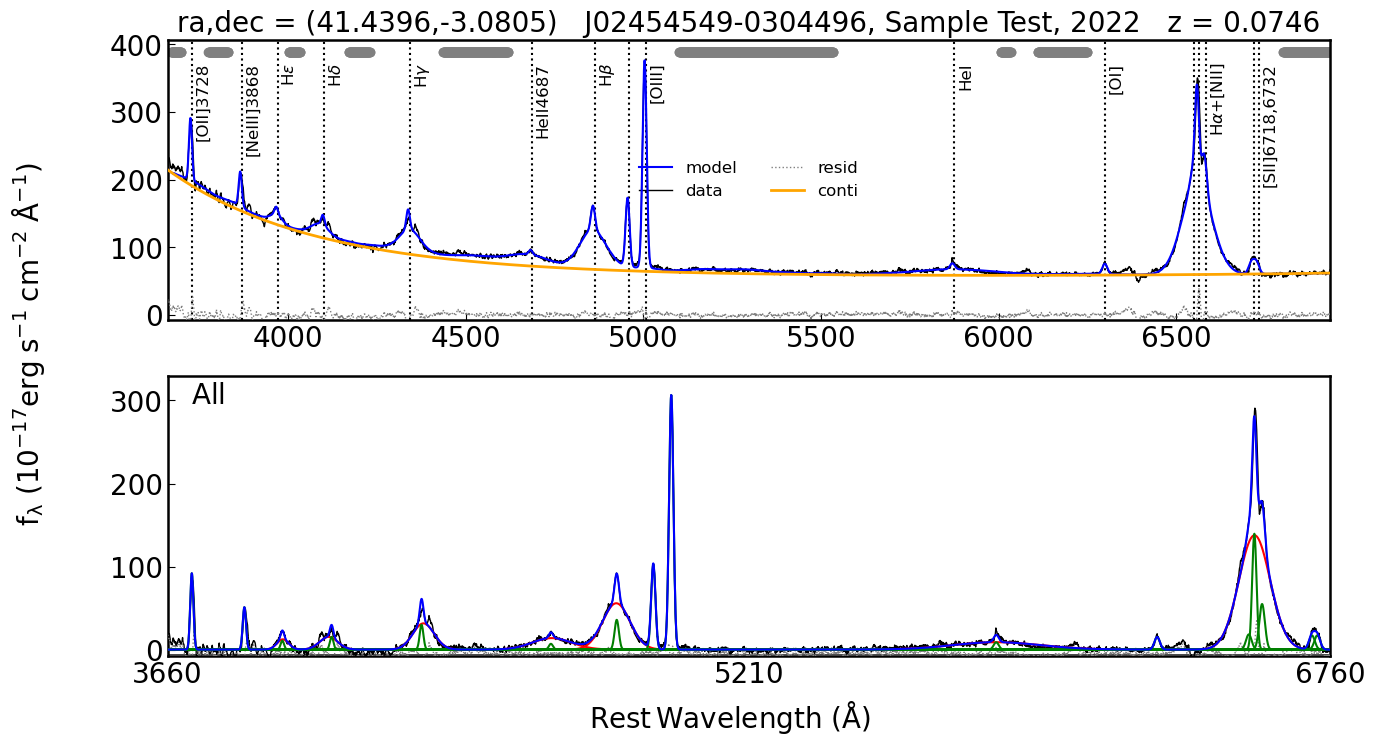

In [233]:
# DataFrame structure
index = ['Ha_br', 'Ha_na', 'NII6549', 'NII6585', 'SII6718', 'SII6732', 'OI6300', 'HeI5875_br', 'HeI5875_na', 'Hb_br', 'Hb_na', 'OIII4959c', 'OIII5007c', 'HeII4687_br', 'HeII4687_na', 'Hg_br', 'Hd_br', 'Hep_br', 'Hep_na', 'NeIII3868', 'OII3728']

# Dictionary to store DataFrames
dataframes = {}

# Loop to fit spectra
for i in range(5):
    
    # Alter initial line priors
    adjusted_line_priors = line_priors # create copy of line_priors to be altered
    for l in range(len(line_priors)): # loop over each line
        # Change initial scale
        adjusted_line_priors[l][6] = r.gauss(mu = line_priors[l][6], sigma = 0.1*line_priors[l][6]) # gaussian distribution centered on original val, sigma of 10%
        # Change initial sigma
        adjusted_line_priors[l][9] = r.gauss(mu = line_priors[l][9], sigma = 0.1*line_priors[l][9])
    
    # Resample spectra to simulate different noise
    bin = 0 # wavelength bin
    adjusted_flux = np.zeros_like(flux)
    for f in range(len(adjusted_flux)):
        
        # Loop to find which bin 
        wav_bin_found = False
        while wav_bin_found == False:
            if f < bounds_index[bin]: # is this flux value in current 100A wav bin
                resid_sigma = residual_std[b]
                wav_bin_found = True
            else:
                bin += 1 # increment to next wavelength bin
        
        adjusted_flux[f] = r.gauss(mu = flux[f], sigma = resid_sigma) # gaussian distribution centered on original spectra flux with sigma of residual s.d.
    
    # Save line info
    hdu1 = fits.BinTableHDU(data=adjusted_line_priors, header=hdr1, name='line_priors')
    
    hdu_list = fits.HDUList([primary_hdu, hdu1, hdu2, hdu3, hdu4])
    hdu_list.writeto(os.path.join(path_ex, 'qsopar.fits'), overwrite=True)
    
    # Run fitting
    q_mcmc = QSOFit(lam, adjusted_flux, err, z, ra=ra, dec=dec, path=path_ex)
    
    start = timeit.default_timer()

    q_mcmc.Fit(name='J02454549-0304496, Sample Test, 2022', nsmooth=1, deredden=False, reject_badpix=False, wave_range=None, \
               wave_mask=None, decompose_host=False, host_prior=False, host_prior_scale=0.1, decomp_na_mask=True, npca_gal=5, host_type='PCA', npca_qso=10, \
               qso_type='DZBIN1', Fe_uv_op=True, poly=True, rej_abs_conti=False, rej_abs_line=True, MCMC=False, nsamp=400, linefit=True, \
               plot_fig=True, save_fig=False, save_result=False, plot_corner=False, kwargs_plot={'save_fig_path': '.'}, save_fits_name=None, verbose=False)
    
    end = timeit.default_timer()
                    
    print(f'Fit_{i} finished in {np.round(end - start, 1)}s')
    
    # Create empty parameter lists
    fwhm_list = []
    sigma_list = []
    ew_list = []
    peak_list = []
    area_list = []
    snr_list = []
    
    for j in range(len(index)): # for each fit line
        fwhm, sigma, ew, peak, area, snr = q_mcmc.line_prop_from_name(line_name[j], line_type[j])
        fwhm_list.append(fwhm)
        sigma_list.append(sigma)
        ew_list.append(ew)
        peak_list.append(peak)
        area_list.append(area)
        snr_list.append(snr)
    
    # Create DataFrame using a dictionary (column-wise)
    df = pd.DataFrame({
        "fwhm": fwhm_list,
        "sigma": sigma_list,
        "ew": ew_list,
        "peak": peak_list,
        "area": area_list,
        "snr": snr_list
    }, index=index)  # Assign row labels
    
    dataframes[f"Fit_{i}"] = df  # Store with a key
    #print(dataframes)
    #plt.plot(lam, adjusted_flux)
#plt.xlim(6000, 6500)
#plt.ylim(0, 150)
#plt.show()

# Access example
#print(dataframes)  # Print first stored DataFrame

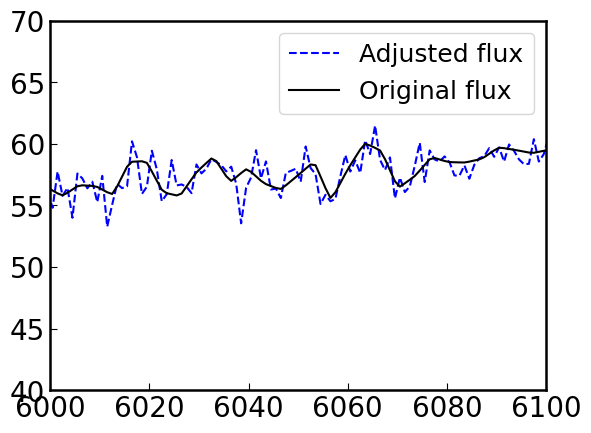

In [235]:
plt.plot(lam, adjusted_flux, color='blue', linestyle='--', label='Adjusted flux')
plt.plot(lam, flux, color = 'black', label='Original flux')
plt.legend()
plt.xlim(6000, 6100)
plt.ylim(40, 70)
plt.show()

In [150]:
adjusted_flux

array([244.56971795, 174.30729787, 252.92298604, ...,  46.04178434,
        63.57911924,  81.07687884])

In [184]:
dataframes['Fit_4']

,fwhm,sigma,ew,peak,area,snr
Ha_br,4607.769522,1930.347794,243.741313,6558.089973,14330.683041,20.761670
Ha_na,637.741657,267.044101,35.823686,6558.265218,2105.662549,14.064552
NII6549,862.965417,361.449897,6.702139,6543.515075,393.457332,1.986969
NII6585,862.965655,361.449997,20.153756,6578.912315,1186.757236,5.717347
SII6718,862.965484,361.449925,5.499922,6711.792629,328.428142,1.286415
SII6732,862.965499,361.449931,5.501988,6726.158719,329.131118,1.326374
OI6300,863.873272,361.830149,5.249882,6300.827770,304.038809,1.796045
HeI5875_br,14106.798397,5913.267699,49.646143,5869.939423,2888.314010,2.222580
HeI5875_na,862.965742,361.450033,3.039360,5869.939423,176.655189,1.715893
Hb_br,5280.348871,2212.408175,74.199013,4857.615994,5050.528818,7.777037


In [38]:
dataframes['Fit_1'].at['Ha_br', 'sigma']

1925.0437213036157

In [107]:
len(dataframes)
for i in dataframes:
    print(i)

Fit_0
Fit_1
Fit_2
Fit_3
Fit_4


In [139]:
adjusted_flux

array([236.96069694, 193.33808796, 242.29083133, ...,  58.30587561,
        59.08337874,  59.86088188])

In [140]:
flux

array([236.96069694, 193.33808796, 242.29083133, ...,  58.30587561,
        59.08337874,  59.86088188])

In [48]:
adjusted_line_priors = line_priors # create copy of line_priors to be altered
for l in range(len(line_priors)): # loop over each line
    # Change initial scale
    adjusted_line_priors[l][6] = r.uniform(adjusted_line_priors[l][7], adjusted_line_priors[l][8]) # uniform random number between min max given values
    # Change initial sigma
    adjusted_line_priors[l][9] = r.uniform(adjusted_line_priors[l][10], adjusted_line_priors[l][11]) # uniform random number between min max given values

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
